In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploration using "dask" and a cluster on AWS.

## Get credentials from .aws/credentials

In the general case, if you only have one set of credentials on aws try the "default" profile

In [28]:
AWS_PROFILE = "mats"

In [29]:
import boto3

session = boto3.Session(profile_name=AWS_PROFILE)
credentials = session.get_credentials()

##  Spin up the cluster using a Fargate Cluster

The cluster shuts down automatically after 20 minutes of inactivity. Use the link to access the dask dashboard.

In [30]:
N_WORKERS = 5

In [31]:
from dask_cloudprovider.aws import FargateCluster
from dask.distributed import Client

# Setup Fargate cluster
cluster = FargateCluster(
    region_name="eu-north-1",
    scheduler_timeout="20 minutes",
    image="daskdev/dask:2024.9.1-py3.12",
    n_workers=N_WORKERS,
    environment={"EXTRA_PIP_PACKAGES": "dask zarr s3fs pyarray xarray"},
    aws_access_key_id=credentials.access_key,
    aws_secret_access_key=credentials.secret_key,
)
cluster.dashboard_link

/usr/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources on AWS. Hang tight! 
  next(self.gen)


'http://13.60.208.214:8787/status'

### Initiate dask using the cluster

In [32]:
client = Client(cluster)

/home/joakim/.virtual_envs/dask_cluster/lib/python3.12/site-packages/distributed/client.py:1606: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+---------+
| Package | Client         | Scheduler      | Workers |
+---------+----------------+----------------+---------+
| python  | 3.12.3.final.0 | 3.12.6.final.0 | None    |
+---------+----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Start exploring the dataset

In this example I'm interested in finding images produced in the "NADLMB" setting.

### Define parameters of interest

I only read the columns from the dataset that I need to use, to limit the transfer from s3 to the workers. I know that the events I'm looking for happens in 2022.

In [39]:
vars = [
    "channel",
    "schedule_name",
    "EXPDate",
]

In [56]:
import dask.dataframe as dd
import s3fs

fs = s3fs.S3FileSystem(
    key=credentials.access_key, secret=credentials.secret_key
)
df = dd.read_parquet(
    "s3://ops-payload-level1b-v0.9/2022", filesystem=fs, columns=vars
)


### Definition of operations i intend to do

First i filter the schedule_name on "NADLMB" - the only mode I'm interested in. Then I group the datset on avaliable channels. Filnally i count the rows where I have data.

In [57]:
df_filtered = df[df["schedule_name"] == "NADLMB"]
df_grouped = df_filtered.groupby("channel")
row_count = df_grouped['EXPDate'].count()

The compute call launches the computation into the cluster

In [58]:
row_count.compute()

channel
NADIR    50
Name: EXPDate, dtype: int64

Since i now know the size of the data i can decide to download the full dataset to my laptop

In [59]:
df_nadir = df_filtered.compute()

df_nadir is know a local Pandas DataFrame, and contiue my work.

In [60]:
df_nadir

,channel,schedule_name,EXPDate
0,NADIR,NADLMB,2022-12-01 11:06:31.479766846+00:00
1,NADIR,NADLMB,2022-12-01 11:08:31.490463257+00:00
2,NADIR,NADLMB,2022-12-01 11:10:31.016754150+00:00
3,NADIR,NADLMB,2022-12-01 11:12:31.094329834+00:00
4,NADIR,NADLMB,2022-12-01 11:14:31.114685059+00:00
5,NADIR,NADLMB,2022-12-01 11:16:31.135025024+00:00
6,NADIR,NADLMB,2022-12-01 11:18:31.164550781+00:00
7,NADIR,NADLMB,2022-12-01 11:20:31.177505493+00:00
8,NADIR,NADLMB,2022-12-01 11:22:31.245010376+00:00
9,NADIR,NADLMB,2022-12-01 11:24:31.305984497+00:00


<Axes: xlabel='EXPDate'>

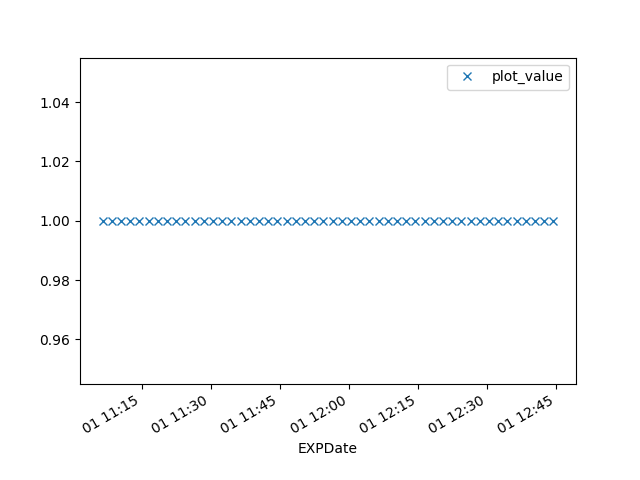

In [61]:
df_nadir['plot_value'] =1
df_nadir.set_index('EXPDate', inplace=True)
df_nadir.plot(marker='x',linestyle="")

Now when I know when I have data i want to se the images. I'm only interested in December 1 2022.

In [62]:
df_images = dd.read_parquet(
    "s3://ops-payload-level1b-v0.9/2022/12/1", filesystem=fs, columns=vars + ['ImageCalibrated']
)
df_images_filtered = df_images[(df_images["schedule_name"] == "NADLMB") & (df_images["channel"]=='NADIR')].compute()

In [63]:
import numpy as np
images = np.stack(df_images_filtered.ImageCalibrated.apply(lambda x: np.stack(x))).astype("float32")
images.shape

(50, 511, 2048)

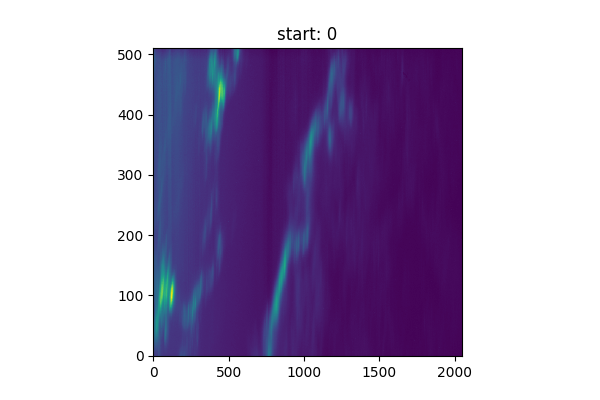

In [67]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(images[0,:,:], cmap='viridis',interpolation='nearest', aspect=4)
ax.invert_yaxis()
title = ax.set_title("start: 0")

def animate(i):
    img.set_data(images[i,:,:])
    title.set_text(f"Time: {i}")
    return img, title

ani = animation.FuncAnimation(
    fig, animate,
    frames=images.shape[0],
    interval=500,
    blit=False,
    repeat=True
)


intentional stop of execution

In [68]:
raise(KeyboardInterrupt)

KeyboardInterrupt: 

In [66]:
plt.close("all")

In [21]:
client.close()

In [18]:
cluster.close()